In [5]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
from scipy import sparse
import matplotlib.pyplot as plt


Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))




======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [33]:
# -------- Insert your code here -------- #
num_driver = len(rho)
filename_save_out = 'Losses_out'


if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    y = np.zeros((Nout, num_driver))  #credit driver factor
    Losses_out = np.zeros((Nout,K)) #out-of-sample loss

    # -------- Insert your code here -------- #

    for s in range(1, Nout+1):
        # -------- Insert your code here -------- #
        normal_factor = np.random.normal(0, 1, (num_driver,1))
        y[s-1,:] = np.dot(sqrt_rho,normal_factor).T
        z = np.random.normal(0, 1, (K, 1)) #Idiosyncratic factor
        
        for i in range(K):
            credit_driver = driver[i]
            if credit_driver != 50:
                w = beta[i]*y[s-1,int(credit_driver)] + math.sqrt(1-beta[i]**2)*z[i]  
            credit_sort = sorted(np.append(w, CS_Bdry[i,:]))  # sort the credit map from the lowest
            # Calculated out-of-sample losses (100000 x 100)
            Losses_out[s-1,i] = exposure[i, np.argwhere(credit_sort == w)]
            
    # Losses_out (sparse matrix)        
    Losses_out = sparse.csr_matrix(Losses_out)
    scipy.sparse.save_npz(filename_save_out + '.npz', Losses_out)

Losses_out_array = Losses_out.toarray()

In [34]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        losses = sorted(np.dot(Losses_out_array,x0[portN]))
        VaRout[portN, q] = losses[int(math.ceil(Nout * alf)) -1]
        VaRinN[portN, q] = np.mean(losses) + scs.norm.ppf(alf) * np.std(losses)
        CVaRout[portN, q] = (1 / (Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf) * VaRout[portN,q] + sum(losses[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(losses) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(losses)



In [36]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    y_MC1 = np.zeros((np.int(np.ceil(Nin/Ns)), num_driver))  #credit driver factor
    Losses_inMC1 = np.zeros((Nin,K)) #loss in Monte Carlo approximation 1

    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        normal_factor_MC1 = np.random.normal(0, 1, (num_driver,1))
        y_MC1[s-1,:] = np.dot(sqrt_rho,normal_factor_MC1).T

        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_MC1 = np.random.normal(0, 1, (K, 1)) #Idiosyncratic factor

    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1
            for i in range(K):
                credit_driver_MC1 = driver[i]
                if credit_driver_MC1 != 50:
                    w_MC1 = beta[i]*y[s-1,int(credit_driver_MC1)] + math.sqrt(1-beta[i]**2)*z_MC1[i]  
                credit_sort_MC1 = sorted(np.append(w_MC1, CS_Bdry[i,:]))  # sort the credit map from the lowest
                Losses_inMC1[5*(s-1)+si-1,i] = exposure[i, np.argwhere(credit_sort_MC1 == w_MC1)]


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    y_MC2 = np.zeros((Nin, num_driver))  #credit driver factor
    Losses_inMC2 = np.zeros((Nin,K)) #loss in Monte Carlo approximation 2

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        normal_factor_MC2 = np.random.normal(0, 1, (num_driver,1))
        y_MC2[s-1,:] = np.dot(sqrt_rho,normal_factor_MC2).T
        z_MC2 = np.random.normal(0, 1, (K, 1)) #Idiosyncratic factor


    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2

        for i in range(K):
            credit_driver_MC2 = driver[i]
            if credit_driver_MC2 != 50:
                w_MC2 = beta[i]*y[s-1,int(credit_driver_MC2)] + math.sqrt(1-beta[i]**2)*z_MC2[i]  
            credit_sort_MC2 = sorted(np.append(w_MC2, CS_Bdry[i,:]))  # sort the credit map from the lowest
            Losses_inMC2[s-1,i] = exposure[i, np.argwhere(credit_sort_MC2 == w_MC2)]

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)

            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)

            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]

            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2

            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))

            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * sigma_p_MC2

# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Portfolio 1:

Out-of-sample: VaR 99.0% = $37999625.38, CVaR 99.0% = $45610879.55
In-sample MC1: VaR 99.0% = $36791135.73, CVaR 99.0% = $44400101.93
In-sample MC2: VaR 99.0% = $38687644.24, CVaR 99.0% = $47047319.63
In-sample No: VaR 99.0% = $26451042.37, CVaR 99.0% = $29380952.18
In-sample N1: VaR 99.0% = $25838327.21, CVaR 99.0% = $28695891.61
In-sample N2: VaR 99.0% = $26903697.74, CVaR 99.0% = $29887871.74

Out-of-sample: VaR 99.9% = $55208324.98, CVaR 99.9% = $62518801.48
In-sample MC1: VaR 99.9% = $53549717.06, CVaR 99.9% = $61905467.69
In-sample MC2: VaR 99.9% = $57034166.92, CVaR 99.9% = $65996636.01
In-sample No: VaR 99.9% = $33055748.09, CVaR 99.9% = $35449518.70
In-sample N1: VaR 99.9% = $32279949.36, CVaR 99.9% = $34614612.92
In-sample N2: VaR 99.9% = $33630727.69, CVaR 99.9% = $36068832.77


Portfolio 2:

Out-of-sample: VaR 99.0% = $27586139.91, CVaR 99.0% = $33543767.15
In-sample MC1: VaR 99.0% = $26291813.96, CVaR 99.0% = $32043143.20
In-sample MC2: VaR 99.0% = $28236926

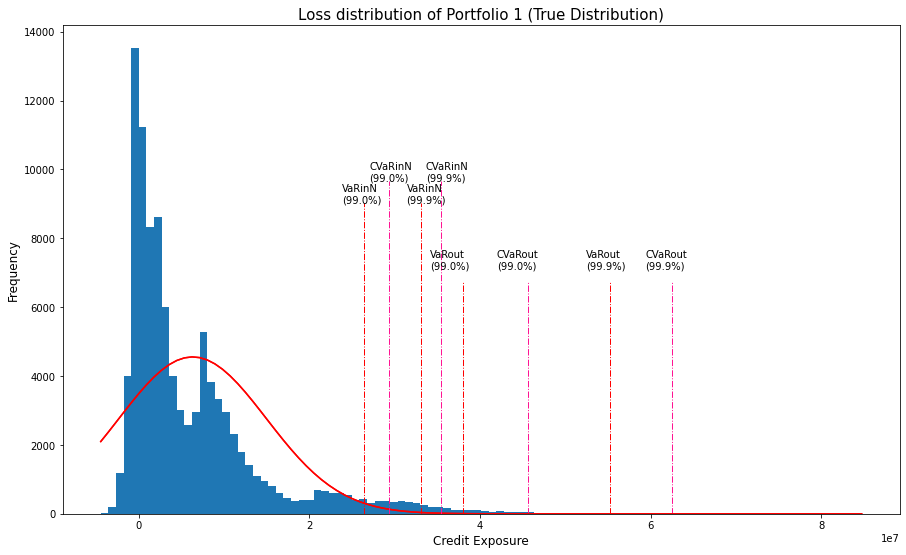

In [37]:
Losses_out_port = []

Losses_out_port.append(np.sort(Losses_out*x0[0]))
Losses_out_port.append(np.sort(Losses_out*x0[1]))

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[0], 100)
normf = (1 / (np.std(Losses_out_port[0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[0])) / np.std(Losses_out_port[0])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[0,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[0,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[0,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[0,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[0,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[0,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[0,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[0,1], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.9%)')

plt.title('Loss distribution of Portfolio 1 (True Distribution)', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);


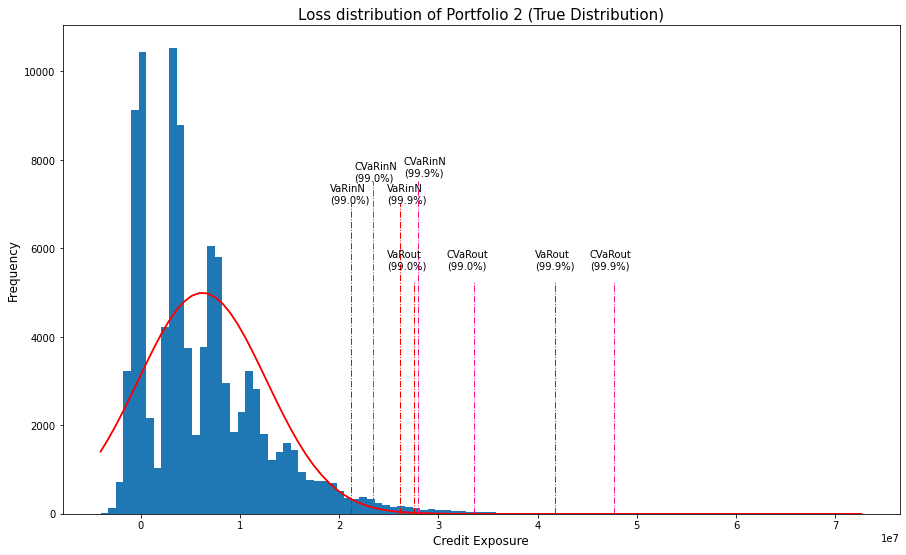

In [38]:
plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[1], 100)
normf = (1 / (np.std(Losses_out_port[1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[1])) / np.std(Losses_out_port[1])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[1,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[1,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[1,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[1,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[1,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[1,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[1,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[1,1], max(frequencyCounts) / 1.38, 'CVaRinN\n(99.9%)')


plt.title('Loss distribution of Portfolio 2 (True Distribution)', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);


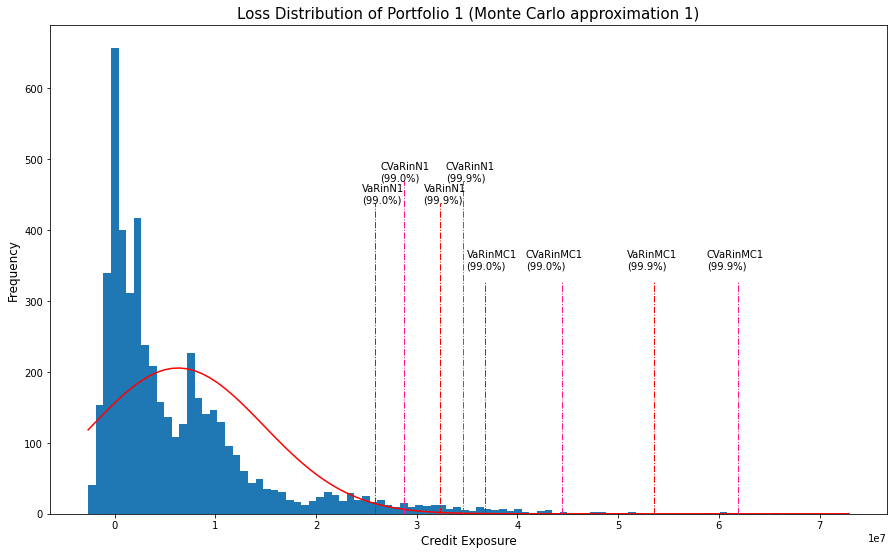

In [57]:
port_loss_inMC1_p1 = np.dot(Losses_inMC1,x0[0])
port_loss_inMC1_p2 = np.dot(Losses_inMC1,x0[1])
port_loss_inMC2_p1 = np.dot(Losses_inMC2,x0[0])
port_loss_inMC2_p2 = np.dot(Losses_inMC2,x0[1])

VaRinMC1_p1_99 = np.mean(VaRinMC1[0, 0])
VaRinMC1_p1_999 = np.mean(VaRinMC1[0, 1])
CVaRinMC1_p1_99 = np.mean(CVaRinMC1[0, 0])
CVaRinMC1_p1_999 = np.mean(CVaRinMC1[0, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC1_p1, 100)
normf = (1 / (np.std(port_loss_inMC1_p1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC1_p1)) / np.std(port_loss_inMC1_p1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC1_p1_99, VaRinMC1_p1_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p1_99, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.0%)')
plt.plot([VaRinMC1_p1_999, VaRinMC1_p1_999], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p1_999, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.9%)')
plt.plot([CVaRinMC1_p1_99, CVaRinMC1_p1_99], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC1_p1_99, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.0%)')
plt.plot([CVaRinMC1_p1_999, CVaRinMC1_p1_999], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC1_p1_999, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.9%)')

VaRinN1_p1_99 = np.mean(VaRinN1[0, 0])
VaRinN1_p1_999 = np.mean(VaRinN1[0, 1])
CVaRinN1_p1_99 = np.mean(CVaRinN1[0, 0])
CVaRinN1_p1_999 = np.mean(CVaRinN1[0, 1])

plt.plot([VaRinN1_p1_99, VaRinN1_p1_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p1_99, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.0%)')
plt.plot([VaRinN1_p1_999, VaRinN1_p1_999], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p1_999, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.9%)')
plt.plot([CVaRinN1_p1_99, CVaRinN1_p1_99], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN1_p1_99, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.0%)')
plt.plot([CVaRinN1_p1_999, CVaRinN1_p1_999], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN1_p1_999, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.9%)')


plt.title('Loss Distribution of Portfolio 1 (Monte Carlo approximation 1)', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

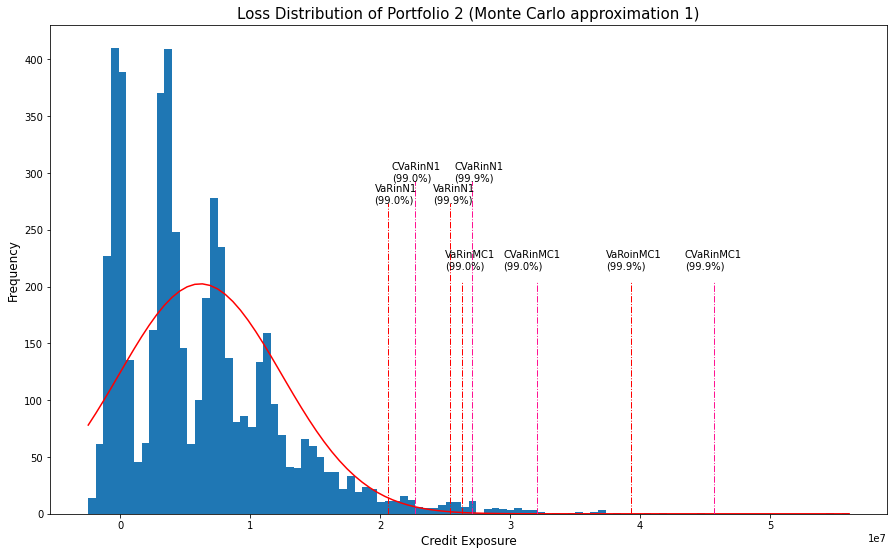

In [58]:
VaRinMC1_p2_99 = np.mean(VaRinMC1[1, 0])
VaRinMC1_p2_999 = np.mean(VaRinMC1[1, 1])
CVaRinMC1_p2_99 = np.mean(CVaRinMC1[1, 0])
CVaRinMC1_p2_999 = np.mean(CVaRinMC1[1, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC1_p2, 100)
normf = (1 / (np.std(port_loss_inMC1_p2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC1_p2)) / np.std(port_loss_inMC1_p2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC1_p2_99, VaRinMC1_p2_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p2_99, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.0%)')
plt.plot([VaRinMC1_p2_999, VaRinMC1_p2_999], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p2_999, max(frequencyCounts) / 1.9, 'VaRoinMC1\n(99.9%)')
plt.plot([CVaRinMC1_p2_99, CVaRinMC1_p2_99], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC1_p2_99, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.0%)')
plt.plot([CVaRinMC1_p2_999, CVaRinMC1_p2_999], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC1_p2_999, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.9%)')

VaRinN1_p2_99 = np.mean(VaRinN1[1, 0])
VaRinN1_p2_999 = np.mean(VaRinN1[1, 1])
CVaRinN1_p2_99 = np.mean(CVaRinN1[1, 0])
CVaRinN1_p2_999 = np.mean(CVaRinN1[1, 1])

plt.plot([VaRinN1_p2_99, VaRinN1_p2_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p2_99, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.0%)')
plt.plot([VaRinN1_p2_999, VaRinN1_p2_999], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p2_999, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.9%)')
plt.plot([CVaRinN1_p2_99, CVaRinN1_p2_99], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN1_p2_99, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.0%)')
plt.plot([CVaRinN1_p2_999, CVaRinN1_p2_999], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN1_p2_999, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.9%)')


plt.title('Loss Distribution of Portfolio 2 (Monte Carlo approximation 1)', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

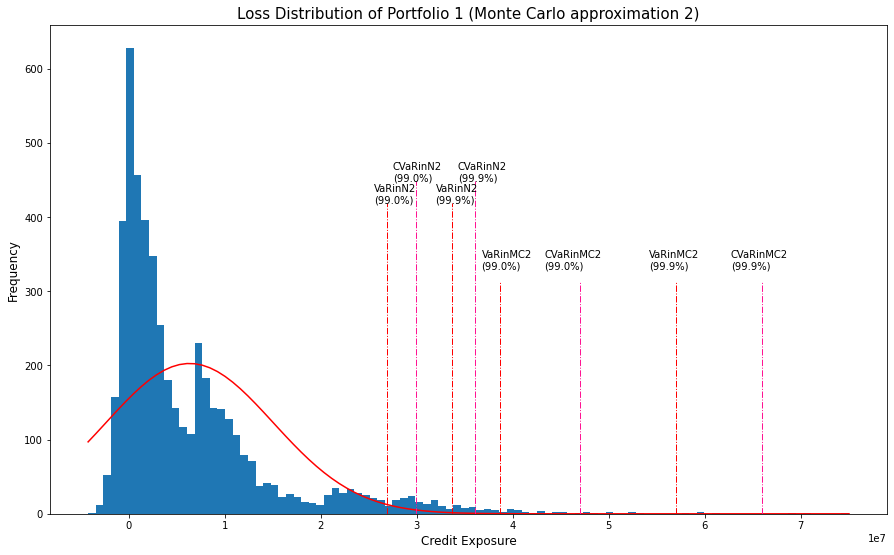

In [59]:
VaRinMC2_p1_99 = np.mean(VaRinMC2[0, 0])
VaRinMC2_p1_999 = np.mean(VaRinMC2[0, 1])
CVaRinMC2_p1_99 = np.mean(CVaRinMC2[0, 0])
CVaRinMC2_p1_999 = np.mean(CVaRinMC2[0, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC2_p1, 100)
normf = (1 / (np.std(port_loss_inMC2_p1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC2_p1)) / np.std(port_loss_inMC2_p1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC2_p1_99, VaRinMC2_p1_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p1_99, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.0%)')
plt.plot([VaRinMC2_p1_999, VaRinMC2_p1_999], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p1_999, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.9%)')
plt.plot([CVaRinMC2_p1_99, CVaRinMC2_p1_99], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC2_p1_99, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.0%)')
plt.plot([CVaRinMC2_p1_999, CVaRinMC2_p1_999], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC2_p1_999, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.9%)')

VaRinN2_p1_99 = np.mean(VaRinN2[0, 0])
VaRinN2_p1_999 = np.mean(VaRinN2[0, 1])
CVaRinN2_p1_99 = np.mean(CVaRinN2[0, 0])
CVaRinN2_p1_999 = np.mean(CVaRinN2[0, 1])

plt.plot([VaRinN2_p1_99, VaRinN2_p1_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p1_99, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.0%)')
plt.plot([VaRinN2_p1_999, VaRinN2_p1_999], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p1_999, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.9%)')
plt.plot([CVaRinN2_p1_99, CVaRinN2_p1_99], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN2_p1_99, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.0%)')
plt.plot([CVaRinN2_p1_999, CVaRinN2_p1_999], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN2_p1_999, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.9%)')

plt.title('Loss Distribution of Portfolio 1 (Monte Carlo approximation 2)', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

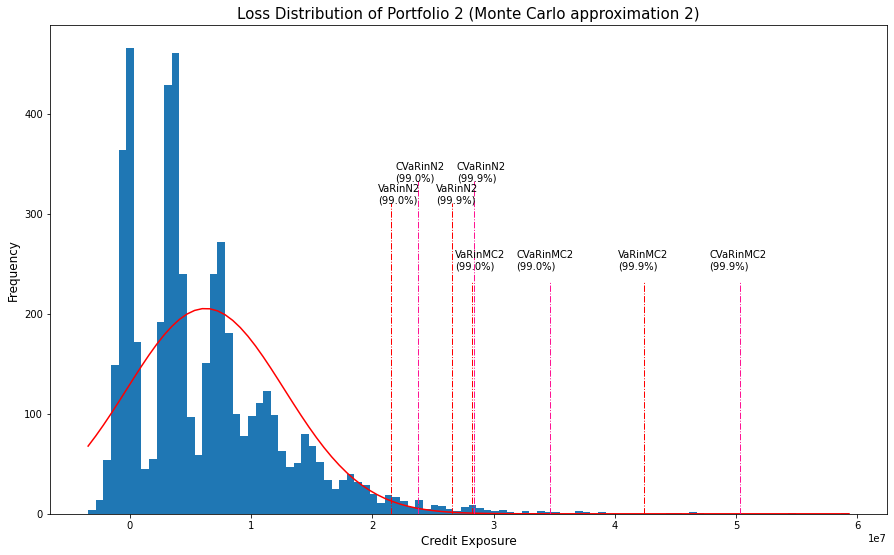

In [60]:
VaRinMC2_p2_99 = np.mean(VaRinMC2[1, 0])
VaRinMC2_p2_999 = np.mean(VaRinMC2[1, 1])
CVaRinMC2_p2_99 = np.mean(CVaRinMC2[1, 0])
CVaRinMC2_p2_999 = np.mean(CVaRinMC2[1, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC2_p2, 100)
normf = (1 / (np.std(port_loss_inMC2_p2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC2_p2)) / np.std(port_loss_inMC2_p2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC2_p2_99, VaRinMC2_p2_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p2_99, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.0%)')
plt.plot([VaRinMC2_p2_999, VaRinMC2_p2_999], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p2_999, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.9%)')
plt.plot([CVaRinMC2_p2_99, CVaRinMC2_p2_99], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC2_p2_99, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.0%)')
plt.plot([CVaRinMC2_p2_999, CVaRinMC2_p2_999], [0, max(frequencyCounts)/2], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC2_p2_999, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.9%)')

VaRinN2_p2_99 = np.mean(VaRinN2[1, 0])
VaRinN2_p2_999 = np.mean(VaRinN2[1, 1])
CVaRinN2_p2_99 = np.mean(CVaRinN2[1, 0])
CVaRinN2_p2_999 = np.mean(CVaRinN2[1, 1])

plt.plot([VaRinN2_p2_99, VaRinN2_p2_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p2_99, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.0%)')
plt.plot([VaRinN2_p2_999, VaRinN2_p2_999], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p2_999, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.9%)')
plt.plot([CVaRinN2_p2_99, CVaRinN2_p2_99], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN2_p2_99, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.0%)')
plt.plot([CVaRinN2_p2_999, CVaRinN2_p2_999], [0, max(frequencyCounts)/1.4], color='deeppink', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN2_p2_999, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.9%)')


plt.title('Loss Distribution of Portfolio 2 (Monte Carlo approximation 2)', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

In [61]:
# sampling error

pd.reset_option('^display.', silent=True)
df1 = pd.DataFrame(columns=['In-sample value','True distribution value','Percent difference (sampling error)'])

df1.loc['99% VaR, MC1, Portfolio 1'] = [VaRinMC1_p1_99,VaRout[0, 0],abs(VaRinMC1_p1_99-VaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% CVaR, MC1, Portfolio 1'] = [CVaRinMC1_p1_99,CVaRout[0, 0],abs(CVaRinMC1_p1_99-CVaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% VaR, MC2, Portfolio 1'] = [VaRinMC2_p1_99,VaRout[0, 0],abs(VaRinMC2_p1_99-VaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% CVaR, MC2, Portfolio 1'] = [CVaRinMC2_p1_99,CVaRout[0, 0],abs(CVaRinMC2_p1_99-CVaRout[0, 0])/VaRout[0, 0]*100]

df1.loc['99.9% VaR, MC1, Portfolio 1'] = [VaRinMC1_p1_999,VaRout[0, 1],abs(VaRinMC1_p1_999-VaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% CVaR, MC1, Portfolio 1'] = [CVaRinMC1_p1_999,CVaRout[0, 1],abs(CVaRinMC1_p1_999-CVaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% VaR, MC2, Portfolio 1'] = [VaRinMC2_p1_999,VaRout[0, 1],abs(VaRinMC2_p1_999-VaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% CVaR, MC2, Portfolio 1'] = [CVaRinMC2_p1_999,CVaRout[0, 1],abs(CVaRinMC2_p1_999-CVaRout[0, 1])/VaRout[0, 1]*100]

df1.loc['99% VaR, MC1, Portfolio 2'] = [VaRinMC1_p2_99,VaRout[1, 0],abs(VaRinMC1_p2_99-VaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% CVaR, MC1, Portfolio 2'] = [CVaRinMC1_p2_99,CVaRout[1, 0],abs(CVaRinMC1_p2_99-CVaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% VaR, MC2, Portfolio 2'] = [VaRinMC2_p2_99,VaRout[1, 0],abs(VaRinMC2_p2_99-VaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% CVaR, MC2, Portfolio 2'] = [CVaRinMC2_p2_99,CVaRout[1, 0],abs(CVaRinMC2_p2_99-CVaRout[1, 0])/VaRout[1, 0]*100]

df1.loc['99.9% VaR, MC1, Portfolio 2'] = [VaRinMC1_p2_999,VaRout[1, 1],abs(VaRinMC1_p2_999-VaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% CVaR, MC1, Portfolio 2'] = [CVaRinMC1_p2_999,CVaRout[1, 1],abs(CVaRinMC1_p2_999-CVaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% VaR, MC2, Portfolio 2'] = [VaRinMC2_p2_999,VaRout[1, 1],abs(VaRinMC2_p2_999-VaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% CVaR, MC2, Portfolio 2'] = [CVaRinMC2_p2_999,CVaRout[1, 1],abs(CVaRinMC2_p2_999-CVaRout[1, 1])/VaRout[1, 1]*100]

df1['In-sample value'] = df1['In-sample value'].map('${:,.2f}'.format)
df1['True distribution value'] = df1['True distribution value'].map('${:,.2f}'.format)
df1['Percent difference (sampling error)'] = df1['Percent difference (sampling error)'].map("{:,.2f}%".format)
df1

,In-sample value,True distribution value,Percent difference (sampling error)
"99% VaR, MC1, Portfolio 1","$36,791,135.73","$37,999,625.38",3.18%
"99% CVaR, MC1, Portfolio 1","$44,400,101.93","$45,610,879.55",3.19%
"99% VaR, MC2, Portfolio 1","$38,687,644.24","$37,999,625.38",1.81%
"99% CVaR, MC2, Portfolio 1","$47,047,319.63","$45,610,879.55",3.78%
"99.9% VaR, MC1, Portfolio 1","$53,549,717.06","$55,208,324.98",3.00%
"99.9% CVaR, MC1, Portfolio 1","$61,905,467.69","$62,518,801.48",1.11%
"99.9% VaR, MC2, Portfolio 1","$57,034,166.92","$55,208,324.98",3.31%
"99.9% CVaR, MC2, Portfolio 1","$65,996,636.01","$62,518,801.48",6.30%
"99% VaR, MC1, Portfolio 2","$26,291,813.96","$27,586,139.91",4.69%
"99% CVaR, MC1, Portfolio 2","$32,043,143.20","$33,543,767.15",5.44%


In [62]:
# model error

df2 = pd.DataFrame(columns=['Normal model value','True distribution value','Percent difference (model error)'])

df2.loc['99% VaR, N1, Portfolio 1'] = [VaRinN1_p1_99,VaRout[0, 0],abs(VaRinN1_p1_99-VaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% CVaR, N1, Portfolio 1'] = [CVaRinN1_p1_99,CVaRout[0, 0],abs(CVaRinN1_p1_99-CVaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% VaR, N2, Portfolio 1'] = [VaRinN2_p1_99,VaRout[0, 0],abs(VaRinN2_p1_99-VaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% CVaR, N2, Portfolio 1'] = [CVaRinN2_p1_99,CVaRout[0, 0],abs(CVaRinN2_p1_99-CVaRout[0, 0])/VaRout[0, 0]*100]

df2.loc['99.9% VaR, N1, Portfolio 1'] = [VaRinN1_p1_999,VaRout[0, 1],abs(VaRinN1_p1_999-VaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% CVaR, N1, Portfolio 1'] = [CVaRinN1_p1_999,CVaRout[0, 1],abs(CVaRinN1_p1_999-CVaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% VaR, N2, Portfolio 1'] = [VaRinN2_p1_999,VaRout[0, 1],abs(VaRinN2_p1_999-VaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% CVaR, N2, Portfolio 1'] = [CVaRinN2_p1_999,CVaRout[0, 1],abs(CVaRinN2_p1_999-CVaRout[0, 1])/VaRout[0, 1]*100]

df2.loc['99% VaR, N1, Portfolio 2'] = [VaRinN1_p2_99,VaRout[1, 0],abs(VaRinN1_p2_99-VaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% CVaR, N1, Portfolio 2'] = [CVaRinN1_p2_99,CVaRout[1, 0],abs(CVaRinN1_p2_99-CVaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% VaR, N2, Portfolio 2'] = [VaRinN2_p2_99,VaRout[1, 0],abs(VaRinN2_p2_99-VaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% CVaR, N2, Portfolio 2'] = [CVaRinN2_p2_99,CVaRout[1, 0],abs(CVaRinN2_p2_99-CVaRout[1, 0])/VaRout[1, 0]*100]

df2.loc['99.9% VaR, N1, Portfolio 2'] = [VaRinN1_p2_999,VaRout[1, 1],abs(VaRinN1_p2_999-VaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% CVaR, N1, Portfolio 2'] = [CVaRinN1_p2_999,CVaRout[1, 1],abs(CVaRinN1_p2_999-CVaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% VaR, N2, Portfolio 2'] = [VaRinN2_p2_999,VaRout[1, 1],abs(VaRinN2_p2_999-VaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% CVaR, N2, Portfolio 2'] = [CVaRinN2_p2_999,CVaRout[1, 1],abs(CVaRinN2_p2_999-CVaRout[1, 1])/VaRout[1, 1]*100]

df2['Normal model value'] = df2['Normal model value'].map('${:,.2f}'.format)
df2['True distribution value'] = df2['True distribution value'].map('${:,.2f}'.format)
df2['Percent difference (model error)'] = df2['Percent difference (model error)'].map("{:,.2f}%".format)
df2

,Normal model value,True distribution value,Percent difference (model error)
"99% VaR, N1, Portfolio 1","$25,838,327.21","$37,999,625.38",32.00%
"99% CVaR, N1, Portfolio 1","$28,695,891.61","$45,610,879.55",44.51%
"99% VaR, N2, Portfolio 1","$26,903,697.74","$37,999,625.38",29.20%
"99% CVaR, N2, Portfolio 1","$29,887,871.74","$45,610,879.55",41.38%
"99.9% VaR, N1, Portfolio 1","$32,279,949.36","$55,208,324.98",41.53%
"99.9% CVaR, N1, Portfolio 1","$34,614,612.92","$62,518,801.48",50.54%
"99.9% VaR, N2, Portfolio 1","$33,630,727.69","$55,208,324.98",39.08%
"99.9% CVaR, N2, Portfolio 1","$36,068,832.77","$62,518,801.48",47.91%
"99% VaR, N1, Portfolio 2","$20,588,325.25","$27,586,139.91",25.37%
"99% CVaR, N1, Portfolio 2","$22,697,718.48","$33,543,767.15",39.32%
